In [1]:
import cv2
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, "../../PRNet")
from api import PRN
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '' # cpu
prn = PRN(is_dlib = True, prefix="../../PRNet")
from utils.render import render_texture
from utils.rotate_vertices import frontalize
from utils.estimate_pose import estimate_pose
import numpy as np

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
Please use `layer.__call__` method instead.





INFO:tensorflow:Restoring parameters from ../../PRNet/Data/net-data/256_256_resfcn256_weight


(-0.01795023267708566, 0.0854578487172203, -0.11464981355619325)


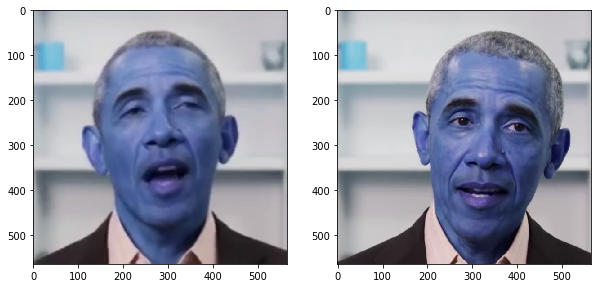

In [2]:
import pickle
import matplotlib.pyplot as plt
def load_information(file):
    return pickle.load(open(file, 'rb'))



info_syn = load_information("../../PRNet/notebooks/synthesis/28.pickle")
info_HD = load_information("../../PRNet/notebooks/HD/338.pickle")
fig, ax = plt.subplots(1,2,figsize=(10,5))


print(info_syn["pose"])
ax[0].imshow(info_syn["img"])
ax[1].imshow(info_HD["img"])


In [3]:
def rotate_to_hd(syn_info, hd_info):
    """
    Input image --> Ref image
    """
    warp_vertices = np.matmul(np.matmul(syn_info["vertices"],syn_info["R"]), np.linalg.inv(hd_info["R"])) 
    center2_warp_pt = np.mean(warp_vertices, axis=0)
    center1_pt = np.mean(hd_info["vertices"], axis=0)
    warp_vertices -= ((center2_warp_pt - center1_pt))
    syn_info["warp_vertices"] = warp_vertices

    if 'lmks' in syn_info.keys():
        new_lmk = np.matmul(np.matmul(syn_info["lmks"],syn_info["R"]), np.linalg.inv(hd_info["R"]))
        new_lmk = new_lmk- (center2_warp_pt - center1_pt)
        syn_info["warp_lmks"] = new_lmk

    return syn_info

def l2_loss(a,b):
    return np.linalg.norm(a-b)

def draw_landmark(im, l, color =(0,255,0)):
    im_ = im.copy()
    for i in l:
        cv2.circle(im_, (int(i[0]),int(i[1])), 3,color, -1)

    return im_
    

def find_better_hd_image(syn_info, hd_info, all_hd_infos):
    # Add landmarks to syn_info, hd_info, all_hd_infos
    syn_info["lmks"] = prn.get_landmarks(syn_info["pos"])
    hd_info["lmks"] = prn.get_landmarks(hd_info["pos"])
    for info in all_hd_infos:
        info["lmks"] = prn.get_landmarks(info["pos"])

    # Warp infomation of syn_info and all_hd_infos
    syn_info = rotate_to_hd(syn_info, hd_info)
    for info in all_hd_infos:
        rotate_to_hd(info, hd_info)
    

    # Find the best index of all_hd_info that match the syn_info
    # Now, basically just based on the L2 loss of those landmarks 
    # Sorted and return the hd_info that have the minimum L2 3D landmarks loss
    fullmouth = list(range(48, 68)) 
    # mouth = list(range(48,60))
    # left_eyes = list(range(36,42))
    # right_eyes = list(range(42,48))
    # interested_landmaks = mouth + left_eyes + right_eyes
    interested_landmaks = fullmouth 
    # interested_landmaks = left_eyes + right_eyes

    # Filter hd info that have pose that match to the hd image
    # l2_loss_poses = [l2_loss(np.array(hd_info["pose"]), np.array(info['pose'])) for info in all_hd_infos]
    # indices_good_poses = np.argsort(l2_loss_poses)[:25]
    # all_hd_infos = [all_hd_infos[i] for i in indices_good_poses]
    # print("Len d info have good pose: ", len(all_hd_infos))


    l2_losses = [l2_loss(syn_info["warp_lmks"][interested_landmaks], info["warp_lmks"][interested_landmaks]) for info in all_hd_infos]
    # indices_better_hd = np.argsort(l2_losses)[:5] 
    # return [all_hd_info[i] for i in indices_better_hd], syn_info
    index_best_fit_hd_image = np.argmin(l2_losses)
    return all_hd_infos[index_best_fit_hd_image], syn_info


def render_new_image(info):
    texture_ref = cv2.remap(info["img"]/255.0, info["pos"][:,:,:2].astype(np.float32), None, interpolation=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT,borderValue=(0))
    # print("Texture from pos map: ", time.time()-t1)

    [h, w, c] = info_syn["img"].shape
    # t1 = time.time()

    color = prn.get_colors_from_texture(texture_ref)
    # print("Get color of texture: ", time.time()-t1)

    new_image = render_texture(info["warp_vertices"].T, color.T, prn.triangles.T, h, w, c = 3)
    return new_image

def swap_image(hd_image, better_hd_info):
    texture_ref = cv2.remap(better_hd_info["img"]/255.0, better_hd_info["pos"][:,:,:2].astype(np.float32), None, interpolation=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT,borderValue=(0))

    [h, w, c] = hd_image.shape

    color = prn.get_colors_from_texture(texture_ref)
    
    color_mask = np.ones((better_hd_info["warp_vertices"].shape[0], 1))
    new_image = render_texture(better_hd_info["warp_vertices"].T, color.T, prn.triangles.T, h, w, c = 3)
    facemask = render_texture(better_hd_info["warp_vertices"].T, color_mask.T, prn.triangles.T, h, w, c = 3)

    # cv2.imshow("New image", new_image)
    # cv2.imshow("hd_image", hd_image) 

    # k = cv2.waitKey(0)

    # Using seamlessCloning to blending images
    vis_ind = np.argwhere(facemask>0)
    vis_min = np.min(vis_ind, 0)
    vis_max = np.max(vis_ind, 0)
    center = (int((vis_min[1] + vis_max[1])/2+0.5), int((vis_min[0] + vis_max[0])/2+0.5))
    output = cv2.seamlessClone((new_image*255).astype(np.uint8),(hd_image).astype(np.uint8), (facemask*255).astype(np.uint8), center, cv2.NORMAL_CLONE)

    return output


def warp_high_res_face(in_info, hd_info, all_hd_info):
    best_warp_hd_info, warp_in_info = find_better_hd_image(in_info, hd_info, all_hd_info)
    best_hd_image = render_new_image(best_warp_hd_info)
    return best_hd_image



# Clean code

# Demo

In [6]:
import glob

out = cv2.VideoWriter('./obama_say_hello.mp4',cv2.VideoWriter_fourcc('M','J','P','G'), 30, (1695, 565))

len_syn_images = len(glob.glob("/home/vuthede/AI/PRNet/notebooks/synthesis1/*.pickle"))

cap = cv2.VideoCapture("../cropdeenglish.mp4")
for i in range(1, len_syn_images+1):
    ret, decrop = cap.read()
    syn_info = load_information(f"/home/vuthede/AI/PRNet/notebooks/synthesis1/{i}.pickle")
    hd_info = load_information(f"/home/vuthede/AI/PRNet/notebooks/HD1/{i}.pickle")
    result = cv2.imread(f"/home/vuthede/AI/PRNet/notebooks/outputobama/{i}.png")

    decrop = cv2.resize(decrop, result.shape[:2][::-1])
    
    cv2.imshow("De crop", decrop)
    cv2.imshow("Synthesis ", syn_info["img"])
    cv2.imshow("Result HD ", result)

    concat = np.hstack([decrop,  syn_info["img"], result])
    print(concat.shape)
    out.write(concat)

    k = cv2.waitKey(0)

    if k==27:
        out.release()
        break

cv2.destroyAllWindows()




(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695

In [ ]:
all_hd_files = glob.glob("./HD1/*.pickle")
all_hd_files = all_hd_files[:300]
all_hd_info = [load_information(f) for f in all_hd_files]



In [13]:
import glob
import cv2
len_syn_images = len(glob.glob("/home/vuthede/AI/PRNet/notebooks/synthesis1/*.pickle"))
cap = cv2.VideoCapture("../cropdeenglish.mp4")
cap1 = cv2.VideoCapture("../resultdeenglish.mp4")



for i in range(1, len_syn_images+1):
    ret, decrop = cap.read()
    ret1, syn_result = cap1.read()

    if not ret or not ret1:
        break
    syn_info = load_information(f"/home/vuthede/AI/PRNet/notebooks/synthesis1/{i}.pickle")
    # hd_info = load_information(f"/home/vuthede/AI/PRNet/notebooks/HD1/{i}.pickle")

    # better_hd_info,_ = find_better_hd_image(syn_info, hd_info, all_hd_info)
    # output1 = swap_image(hd_info["img"], better_hd_info)
    output = cv2.imread(f"/home/vuthede/AI/PRNet/notebooks/outputobama/{i}.png")
    decrop = cv2.resize(decrop, output.shape[:2][::-1])
    syn_result = cv2.resize(syn_result, output.shape[:2][::-1])

    cv2.imshow("De crop ", decrop)

    cv2.imshow("Synthesis", syn_result)

    # cv2.imshow("Synthesis", syn_info["img"])
    # cv2.imshow("Hd ", hd_info["img"])
    cv2.imshow("output ", output)

    k =cv2.waitKey(0)

    if k ==27:
        break
cv2.destroyAllWindows()




    # output = "./outputobama"
    # if not os.path.isdir(output):
    #     os.makedirs(output)

    # cv2.imwrite(f"{output}/{i}.png", output1)
    # print("Yp!!!!")

In [6]:
import glob

all_hd_files = glob.glob("../../PRNet/notebooks/HD/*.pickle")
all_hd_files = all_hd_files[:300]
all_hd_info = [load_information(f) for f in all_hd_files]

len_syn_images = len(glob.glob("../../PRNet/notebooks/synthesis1/*.pickle"))




In [7]:
for i in range(1, len_syn_images):
    syn_info = load_information(f"../../PRNet/notebooks/synthesis1/{i}.pickle")
    hd_info = load_information(f"../../PRNet/notebooks/HD1/{i}.pickle")

    better_hd_info,_ = find_better_hd_image(syn_info, hd_info, all_hd_info)
    output1 = swap_image(hd_info["img"], better_hd_info)

    cv2.imshow("Synthesis:", syn_info["img"])
    cv2.imshow("Hd_info:", hd_info["img"])
    cv2.imshow("swap:", output1)

    k = cv2.waitKey(0)
    if k==27:
        break

cv2.destroyAllWindows()
    # output = "./outputobama"
    # if not os.path.isdir(output):
    #     os.makedirs(output)

    # cv2.imwrite(f"{output}/{i}.png", output1)
    # print("Yp!!!!")

In [8]:
for i in range(1, len_syn_images):
    syn_info = load_information(f"../../PRNet/notebooks/synthesis1/{i}.pickle")
    hd_info = load_information(f"../../PRNet/notebooks/HD1/{i}.pickle")

    output1 = cv2.imread(f"../../PRNet/notebooks/outputobama/{i}.png")

    cv2.imshow("Synthesis:", syn_info["img"])
    cv2.imshow("Hd_info:", hd_info["img"])
    cv2.imshow("swap:", output1)

    k = cv2.waitKey(0)
    if k==27:
        break

cv2.destroyAllWindows()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


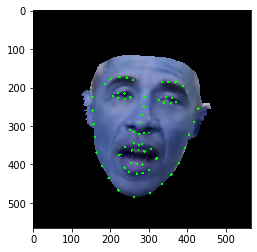

In [35]:
plt.imshow(draw_landmark(new_image, lkm2_new))


In [2]:
img_in = cv2.imread("/home/vuthede/Desktop/3D/31_in.png")

pos1 = prn.process(img_in) 
vertices1 = prn.get_vertices(pos1)
cam_mat1, pose1, R1 = estimate_pose(vertices1)

Here is input:  (565, 565, 3)


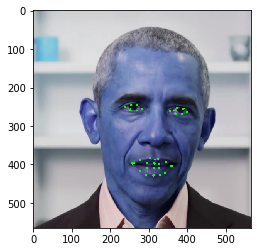

In [5]:
import matplotlib.pyplot as plt

def draw_landmark(im, l, color =(0,255,0)):
    im_ = im.copy()
    for i in l:
        cv2.circle(im_, (int(i[0]),int(i[1])), 3,color, -1)

    return im_
    

mouth = list(range(48, 68)) 
left_eyes = list(range(36,42))
right_eyes = list(range(42,48))
interested_landmaks = mouth + left_eyes + right_eyes

lmk_in = prn.get_landmarks(pos1)
lmk_in = lmk_in[interested_landmaks]
plt.imshow(draw_landmark(img_in, lmk_in))


In [6]:
from numpy as np

def l2_loss(a,b):
    return np.linalg.norm(a-b)

1.4142135623730951

In [32]:
np.argsort([5,4,3,2,1])[:4]

array([4, 3, 2, 1])

In [26]:
a = [1,2,3]
b = [4,5,6]
a-b

TypeError: unsupported operand type(s) for -: 'list' and 'list'